<a href="https://colab.research.google.com/github/Galeano-Garcia-GS/Synergistic-SCFA-production-by-Fiber-Mixture/blob/main/Correlation_heatmap_between_SCFA_production_and_synergy_in_SCFA_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Correlation heatmap between community structure metrics and synergy in SCFA

Find [metadata](https://docs.google.com/spreadsheets/d/1WkbV79p_IPtRoRTBd_aIz_68Df5ms7uy24yDXEpAAIk/edit?usp=sharing) file here.

In [ ]:
#@title Dataframe

install_dependencies = False  #@param {type:"boolean"}
excel_file_path = "/content/Metadata.xlsx"  #@param {type:"string"}
sheet_name = "Full"  #@param {type:"string"}
columns_csv = "Individual, Fiber, Acetate_(mM), Synergy_in_acetate_(%), Butyrate_(mM), Synergy_in_butyrate_(%), Propionate_(mM), Synergy_in_propionate_(%), Total_SCFA_(mM), Synergy_in_total_SCFA_(%)"  #@param {type:"string"}
enable_filtering = True  #@param {type:"boolean"}

output_directory = "/content"  #@param {type:"string"}
output_filename = "Metadata_V1.xlsx"  #@param {type:"string"}
create_directory_if_missing = True  #@param {type:"boolean"}
save_format = "Excel (.xlsx)"  #@param ["Excel (.xlsx)", "CSV (.csv)"]
include_index = False  #@param {type:"boolean"}

import sys, subprocess, os
if install_dependencies:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "pandas", "openpyxl"])

import pandas as pd
from IPython.display import display, HTML
import ipywidgets as widgets

if not os.path.exists(excel_file_path):
    raise FileNotFoundError(f"File not found: {excel_file_path}")

raw_df = pd.read_excel(excel_file_path, sheet_name=sheet_name, header=None)
headers = raw_df.iloc[0].tolist()
types = raw_df.iloc[1].tolist()
data = raw_df.iloc[2:].reset_index(drop=True)
data.columns = headers

selected_columns = [c.strip() for c in columns_csv.split(",") if c.strip()] or headers
missing = [c for c in selected_columns if c not in headers]
if missing:
    raise KeyError(f"Columns not found: {missing}\nAvailable: {headers}")

df_selected = data[selected_columns].copy()
display(HTML("<h4>Preview of selected columns</h4>"))
display(df_selected.head())
print(f"Shape: {df_selected.shape}")

type_map = dict(zip(headers, types))
categorical_cols = [c for c in selected_columns if str(type_map.get(c, "")).lower() == "categorical"]

filter_widgets = {}
clear_buttons = {}

if enable_filtering and categorical_cols:
    display(HTML("<h4>Filters for categorical columns</h4>"))
    cols_ui = []
    for col in categorical_cols:
        unique_vals = df_selected[col].dropna().unique().tolist()
        has_nans = df_selected[col].isna().any()

        ms = widgets.SelectMultiple(options=unique_vals, description=col, layout=widgets.Layout(width="60%"))
        nan_toggle = widgets.Checkbox(value=False, description="Include missing") if has_nans else None
        clear_btn = widgets.Button(description="Clear", button_style="warning", icon="x")

        def make_clear_handler(ms_widget, nan_widget):
            def _handler(_):
                ms_widget.value = ()
                if nan_widget is not None:
                    nan_widget.value = False
            return _handler

        clear_btn.on_click(make_clear_handler(ms, nan_toggle))
        row = widgets.HBox([ms, widgets.VBox(([nan_toggle] if nan_toggle else [])), clear_btn])
        cols_ui.append(row)

        filter_widgets[col] = {"widget": ms, "nan": nan_toggle}
        clear_buttons[col] = clear_btn

    display(widgets.VBox(cols_ui))

apply_button = widgets.Button(description="Apply Filters & Save", button_style="primary", icon="check")
clear_all_button = widgets.Button(description="Clear All Filters", icon="trash")
buttons_bar = widgets.HBox([apply_button, clear_all_button])

output_area = widgets.Output()
display(buttons_bar, output_area)

def clear_all(_):
    for parts in filter_widgets.values():
        parts["widget"].value = ()
        if parts["nan"] is not None:
            parts["nan"].value = False

def apply_filters_and_save(_):
    with output_area:
        output_area.clear_output()
        df_filtered = df_selected.copy()
        if enable_filtering and filter_widgets:
            for col, parts in filter_widgets.items():
                chosen = list(parts["widget"].value)
                include_nan = parts["nan"].value if parts["nan"] else False
                if chosen or include_nan:
                    mask = df_filtered[col].isin(chosen)
                    if include_nan: mask |= df_filtered[col].isna()
                    df_filtered = df_filtered[mask]
        display(HTML("<h4>Final DataFrame</h4>"))
        display(df_filtered)
        print(f"Final shape: {df_filtered.shape}")
        if create_directory_if_missing and not os.path.exists(output_directory):
            os.makedirs(output_directory, exist_ok=True)
        out_path = os.path.join(output_directory, output_filename)
        if save_format.startswith("Excel"):
            if not out_path.lower().endswith(".xlsx"): out_path += ".xlsx"
            df_filtered.to_excel(out_path, index=include_index)
        else:
            if not out_path.lower().endswith(".csv"): out_path += ".csv"
            df_filtered.to_csv(out_path, index=include_index)
        display(HTML(f"<b>Saved to:</b> <code>{out_path}</code>"))

clear_all_button.on_click(clear_all)
apply_button.on_click(apply_filters_and_save)

,Individual,Fiber,Acetate_(mM),Synergy_in_acetate_(%),Butyrate_(mM),Synergy_in_butyrate_(%),Propionate_(mM),Synergy_in_propionate_(%),Total_SCFA_(mM),Synergy_in_total_SCFA_(%)
0,C01,FOS,4.264,NaN,2.285,NaN,3.466,NaN,10.015,NaN
1,C01,FOS,3.717,NaN,1.985,NaN,3.032,NaN,8.734,NaN
2,C01,bGlucan,6.708,NaN,2.039,NaN,3.079,NaN,11.826,NaN
3,C01,bGlucan,2.425,NaN,2.021,NaN,2.983,NaN,7.43,NaN
4,C01,Pectin,7.166,NaN,1.373,NaN,2.314,NaN,10.853,NaN


Shape: (408, 10)


Output()

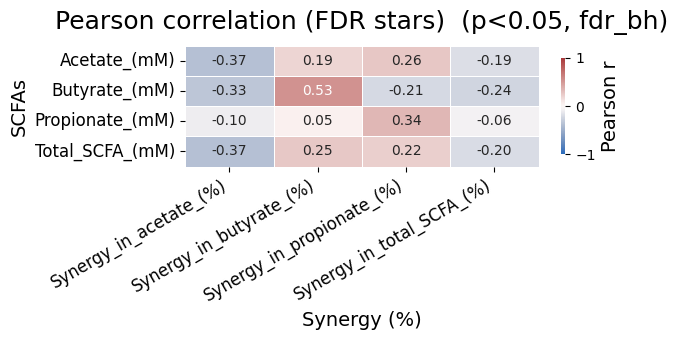

In [ ]:
#@title Plot
#@markdown **How to use:**
#@markdown 1) Set the **file path** and your **Y (rows)** and **X (columns)**.
#@markdown 2) Tweak significance, masking, colors, **font sizes**, and export options.
#@markdown 3) (Optional) aggregate replicates (e.g., by `Individual`) before correlating.
#@markdown 4) Run to render and (optionally) save CSVs/figure.

# ===================== Input / selection =====================
file_path = "Metadata_V1.xlsx"  #@param {type:"string"}
y_cols = "Acetate_(mM), Butyrate_(mM), Propionate_(mM), Total_SCFA_(mM)"  #@param {type:"string"}
x_cols = "Synergy_in_acetate_(%), Synergy_in_butyrate_(%), Synergy_in_propionate_(%), Synergy_in_total_SCFA_(%)"  #@param {type:"string"}

# Optional pre-aggregation of replicates
groupby_cols = "Individual"  #@param {type:"string"}
agg_method = "mean"  #@param ["mean", "median"]

# ===================== Significance & annotation =====================
p_correction = "fdr_bh"  #@param ["none","fdr_bh","bonferroni","holm","sidak"]
p_thresh = 0.05  #@param {type:"slider", min:0.0, max:0.25, step:0.005}
annotate = "both"  #@param ["none","coef","stars","both"]
annot_decimals = 2  #@param {type:"slider", min:0, max:4, step:1}

from scipy.cluster.hierarchy import linkage, leaves_list
# ===================== Clustering options =====================
cluster_rows = False  #@param {type:"boolean"}
cluster_cols = False  #@param {type:"boolean"}

# ===================== Masking options =====================
mask_nonsignificant = False  #@param {type:"boolean"}
mask_upper_triangle = False  #@param {type:"boolean"}
mask_lower_triangle = False  #@param {type:"boolean"}
mask_diagonal = False  #@param {type:"boolean"}

# ===================== Plot appearance =====================
# Colormap list kept short; feel free to expand
cmap = "vlag"  #@param ["vlag","coolwarm","RdBu_r","viridis","magma","rocket","crest","icefire"]
fig_width = 6.5  #@param {type:"slider", min:4.0, max:20.0, step:0.5}
fig_height = 3.5  #@param {type:"slider", min:3.0, max:20.0, step:0.5}
vmin = -1  #@param {type:"slider", min:-1.0, max:0.0, step:0.05}
vmax = 1.0  #@param {type:"slider", min:0.0, max:1.0, step:0.05}
center_zero = True  #@param {type:"boolean"}
robust = False  #@param {type:"boolean"}
alpha = 1  #@param {type:"slider", min:0.1, max:1.0, step:0.05}
linewidths = 0.5  #@param {type:"slider", min:0.0, max:2.0, step:0.1}
linecolor = "white"  #@param ["white","black","#DDDDDD","#333333"]
square = False  #@param {type:"boolean"}

# ===================== Fonts & labels =====================
title_text = "Pearson correlation (FDR stars)"  #@param {type:"string"}
title_fontsize = 18  #@param {type:"slider", min:8, max:36, step:1}
axislabel_fontsize = 14  #@param {type:"slider", min:8, max:30, step:1}
ticklabel_fontsize = 12  #@param {type:"slider", min:6, max:26, step:1}
annot_fontsize = 10  #@param {type:"slider", min:6, max:26, step:1}
xtick_rotation = 30  #@param {type:"slider", min:0, max:90, step:5}
ytick_rotation = 0  #@param {type:"slider", min:-90, max:90, step:5}

# ===================== Colorbar =====================
show_colorbar = True  #@param {type:"boolean"}
cbar_label = "Pearson r"  #@param {type:"string"}
cbar_shrink = 0.8  #@param {type:"slider", min:0.4, max:1.0, step:0.05}
cbar_aspect = 20  #@param {type:"slider", min:5, max:40, step:1}
cbar_ticklabelsize = 10  #@param {type:"slider", min:6, max:26, step:1}

# ===================== Save outputs =====================
output_csv_prefix = ""  #@param {type:"string"}
savefig_path = "/content/"  #@param {type:"string"}
savefig_dpi = 300  #@param {type:"slider", min:72, max:600, step:4}
savefig_transparent = True  #@param {type:"boolean"}
tight_bbox = True  #@param {type:"boolean"}
savefig_svg = "Correlation heatmap between SCFA production and synergy in SCFA script.svg"  #@param {type:"string"}  # e.g., "/content/corr_heatmap.svg" (leave blank to skip)

# ===================== Implementation =====================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

def _parse_cols(s):
    return [re.sub(r'^[\'"]|[\'"]$', '', c.strip()) for c in s.split(",") if c.strip()]

def _star(p):
    if not np.isfinite(p):
        return ""
    return "****" if p < 1e-4 else \
           "***"  if p < 1e-3 else \
           "**"   if p < 1e-2 else \
           "*"    if p < 5e-2 else ""

def _correct_pvals(P, method):
    if method == "none":
        return P.copy()
    methods = {"fdr_bh":"fdr_bh", "bonferroni":"bonferroni", "holm":"holm", "sidak":"sidak"}
    arr = P.to_numpy().ravel()
    finite_mask = np.isfinite(arr)
    padj_all = np.full_like(arr, np.nan, dtype=float)
    _, padj, _, _ = multipletests(arr[finite_mask], method=methods[method])
    padj_all[finite_mask] = padj
    return pd.DataFrame(padj_all.reshape(P.shape), index=P.index, columns=P.columns)

def _aggregate(df, by, method, cols):
    keys = _parse_cols(by)
    if not keys:
        return df
    numeric = df[cols].apply(pd.to_numeric, errors='coerce')
    keep = df.drop(columns=cols).copy()
    df_num = pd.concat([keep, numeric], axis=1)
    if method.lower() == "median":
        out = df_num.groupby(keys, dropna=False).median(numeric_only=True).reset_index()
    else:
        out = df_num.groupby(keys, dropna=False).mean(numeric_only=True).reset_index()
    return out

# Load data
df = pd.read_excel(file_path)

# Select columns and (optional) aggregate
Y = _parse_cols(y_cols)
X = _parse_cols(x_cols)
missing = [c for c in (Y + X) if c not in df.columns]
if missing:
    raise KeyError(f"Columns not found in file: {missing}")

df_use = _aggregate(df.copy(), groupby_cols, agg_method, cols=X+Y)

# To numeric & drop NA
for c in X + Y:
    df_use[c] = pd.to_numeric(df_use[c], errors='coerce')
df_use = df_use.dropna(subset=X+Y, how='any')

# Compute r & p for all YxX
R = pd.DataFrame(index=Y, columns=X, dtype=float)
P = pd.DataFrame(index=Y, columns=X, dtype=float)
for yi in Y:
    for xj in X:
        xi = df_use[xj].to_numpy()
        yi_vals = df_use[yi].to_numpy()
        ok = np.isfinite(xi) & np.isfinite(yi_vals)
        xi = xi[ok]; yi_vals = yi_vals[ok]
        if xi.size >= 2 and np.std(xi) > 0 and np.std(yi_vals) > 0:
            r, p = pearsonr(xi, yi_vals)
        else:
            r, p = np.nan, np.nan
        R.loc[yi, xj] = r
        P.loc[yi, xj] = p

# Adjust p-values
P_adj = _correct_pvals(P, p_correction)

# Annotations
annot_df = False
if annotate != "none":
    annot_df = pd.DataFrame("", index=Y, columns=X, dtype=object)
    for yi in Y:
        for xj in X:
            cells = []
            if annotate in ("coef", "both"):
                r = R.loc[yi, xj]
                cells.append("NA" if not np.isfinite(r) else f"{r:.{annot_decimals}f}")
            if annotate in ("stars", "both"):
                p = P_adj.loc[yi, xj]
                cells.append("" if not np.isfinite(p) else _star(p))
            annot_df.loc[yi, xj] = "\n".join([c for c in cells if c != ""])

# Mask building
mask = np.zeros(R.shape, dtype=bool)
if mask_nonsignificant:
    mask |= ~(P_adj < p_thresh)
if mask_diagonal and len(set(X) & set(Y)) > 0:
    for i, yi in enumerate(Y):
        for j, xj in enumerate(X):
            if yi == xj:
                mask[i, j] = True
if mask_upper_triangle or mask_lower_triangle:
    n = min(len(Y), len(X))
    for i in range(len(Y)):
        for j in range(len(X)):
            if i < n and j < n:
                if mask_upper_triangle and j > i:
                    mask[i, j] = True
                if mask_lower_triangle and i > j:
                    mask[i, j] = True

# Optional Ward clustering
if cluster_rows and len(Y) > 1:
    row_linkage = linkage(R.fillna(0).values, method="ward")
    Y = [Y[i] for i in leaves_list(row_linkage)]

if cluster_cols and len(X) > 1:
    col_linkage = linkage(R.fillna(0).T.values, method="ward")
    X = [X[i] for i in leaves_list(col_linkage)]

# Reindex R, P, and annot if clustering applied
R = R.loc[Y, X]
P = P.loc[Y, X]
P_adj = P_adj.loc[Y, X]
if isinstance(annot_df, pd.DataFrame):
    annot_df = annot_df.loc[Y, X]

# Plot
plt.figure(figsize=(fig_width, fig_height))
ax = sns.heatmap(
    R.astype(float),
    vmin=vmin, vmax=vmax,
    cmap=cmap,
    center=0.0 if center_zero else None,
    robust=robust,
    square=square,
    annot=annot_df,
    annot_kws={"fontsize": annot_fontsize} if isinstance(annot_df, pd.DataFrame) else None,
    fmt="",
    cbar=show_colorbar,
    cbar_kws={"shrink": cbar_shrink, "aspect": cbar_aspect},
    linewidths=linewidths,
    linecolor=linecolor,
    alpha=alpha,
    mask=mask
)

x_label = "Synergy (%)"  #@param {type:"string"}
y_label = "SCFAs"  #@param {type:"string"}
ax.set_xlabel(x_label, fontsize=axislabel_fontsize)
ax.set_ylabel(y_label, fontsize=axislabel_fontsize)
sig_note = f"  (p<{p_thresh}, {p_correction})" if p_correction != "none" else "  (raw p)"
ax.set_title(title_text + sig_note, fontsize=title_fontsize, pad=12)

ax.set_xticklabels(ax.get_xticklabels(), rotation=xtick_rotation, ha="right", fontsize=ticklabel_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), rotation=ytick_rotation, va="center", fontsize=ticklabel_fontsize)

if show_colorbar and ax.collections:
    cb = ax.collections[0].colorbar
    cb.set_label(cbar_label, fontsize=axislabel_fontsize)
    cb.ax.tick_params(labelsize=cbar_ticklabelsize)

plt.tight_layout()

# Save image
if savefig_path.strip():
    plt.savefig(
        savefig_path,
        dpi=int(savefig_dpi),
        transparent=bool(savefig_transparent),
        bbox_inches="tight" if tight_bbox else None
    )

# Save SVG (optional)
if savefig_svg.strip():
    plt.savefig(
        savefig_svg,
        format="svg",
        transparent=bool(savefig_transparent),
        bbox_inches="tight" if tight_bbox else None
    )

plt.show()

# Save matrices
if output_csv_prefix.strip():
    R.to_csv(f"{output_csv_prefix}_R.csv")
    P.to_csv(f"{output_csv_prefix}_P_raw.csv")
    P_adj.to_csv(f"{output_csv_prefix}_P_adj_{p_correction}.csv")
    print(f"Saved CSVs with prefix '{output_csv_prefix}'")